# Extract and analyse summary features

The clustered and projected data can be used to extract different features:

- size per cluster
- mean intensity per cluster
- TODO add more

The features are saved as an adata object.

In [2]:
from miann.tl import Experiment, FeatureExtractor
import os
from miann.pl import plot_mean_intensity, zscore, get_intensity_change, plot_intensity_change, plot_mean_size, plot_size_change
import anndata as ad
from miann.utils import init_logging
init_logging()

## Extract features
Features can be extracted with 
```
# intensity features
python extract_features.py test/CondVAE_pert-CC clustering_0.5 intensity
# spatial co-occurrence
python extract features.py test/CondVAE_pert-CC clustering_0.5 --co-logspace co-occurrence
```


In [2]:
exp = Experiment.from_dir('test/CondVAE_pert-CC')
# just use one dir here, for extracting all features, run the script
data_dir = exp.data_params['data_dirs'][0]
extr = FeatureExtractor(exp, data_dir=data_dir, cluster_name='clustering_0.5', 
                        cluster_dir='aggregated/sub-0.005')

AssertionError: no config.json in test/CondVAE_pert-CC

In [19]:
# extract intensity features
extr.extract_intensity_size()

INFO:FeatureExtractor:Calculating clustering_0.5 (col: clustering_0.5) mean and size for 184A1_unperturbed/I09
INFO:MPPData:Created new: MPPData for NascentRNA (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'labels'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I09.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (7218204 mpps with shape (1, 1, 34) from 557 objects). Data keys: ['clustering_0.5', 'y', 'x', 'obj_ids', 'latent', 'mpp'].
INFO:MPPData:Before subsetting: 886 objects
INFO:MPPData:Subsetting to 557 objects
INFO:MPPData:Updated data to keys ['x', 'y', 'obj_ids', 'mpp', 'labels', 'clustering_0.5', 'latent']
INFO:MPPData:Loaded data from 184A1_unperturbed/I09, with base data from 184A1_unperturbed/I09
INFO:MPPData:Restricted channels to 34 channels
INFO:MPPData:Subtracting channel-specific background value defined in column mean_background
INFO:MPPData:Rescaling MPP intensities per chan

In [ ]:
# extract co-occurence scores: logspace from 2px to 80px
interval = np.logspace(np.log2(2),np.log2(80),10, base=2).astype(np.float32)
extr.extract_co_occurrence(interval)

## Explore extracted features
TODO mean intensity: update using workflow notebook

### Intensity features

In [7]:
extrs = [FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features.h5ad')) for data_dir in exp.data_params['data_dirs']]

# get combined adata for dotplots
adatas = [extr.get_intensity_adata() for extr in extrs]
adata = ad.concat(adatas, index_unique='-')
zscore(adata, limit_to_groups={'perturbation_duration':'unperturbed'})

In [5]:
plot_mean_intensity(adata, groupby='cluster', limit_to_groups={'perturbation_duration':'unperturbed'}, dendrogram=True, layer='zscored', cmap='bwr', vmin=-10, vmax=10)
plot_mean_size(adata, groupby_row='cluster', groupby_col='perturbation_duration', normby_row='all', vmax=0.3)

In [ ]:
res = get_intensity_change(adata, groupby='cluster', reference_group='perturbation_duration', reference='unperturbed', color='logfoldchange', size='pval')
plot_intensity_change(**res, adjust_height=True, figsize=(15,5), vmin=-2, vmax=2, dendrogram=True)

res = get_intensity_change(adata, groupby='cluster', reference_group='perturbation_duration', reference='unperturbed', color='logfoldchange', size='pval', norm_by_group='all')
plot_intensity_change(**res, adjust_height=True, figsize=(15,5), vmin=-2, vmax=2)

### Co-occurrence scores
TODO co-occurrence name!! 

In [101]:
from miann.pl import plot_co_occurrence, plot_co_occurrence_grid

In [18]:
exp = Experiment.from_dir('test/CondVAE_pert-CC')
# load and concat all adatas
extrs = [FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features.h5ad')) for data_dir in exp.data_params['data_dirs']]

# get combined adata
adata = ad.concat([extr.adata for extr in extrs], index_unique='-', uns_merge='same')

INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.005
INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.005
INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.005


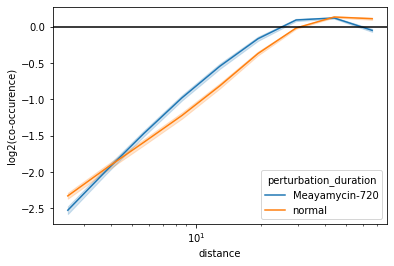

In [102]:
# plot meam co-occ scores
condition = 'perturbation_duration'
condition_values = None

# for one cluster-cluster pairing
plot_co_occurrence(adata, '0', '1', condition, condition_values)

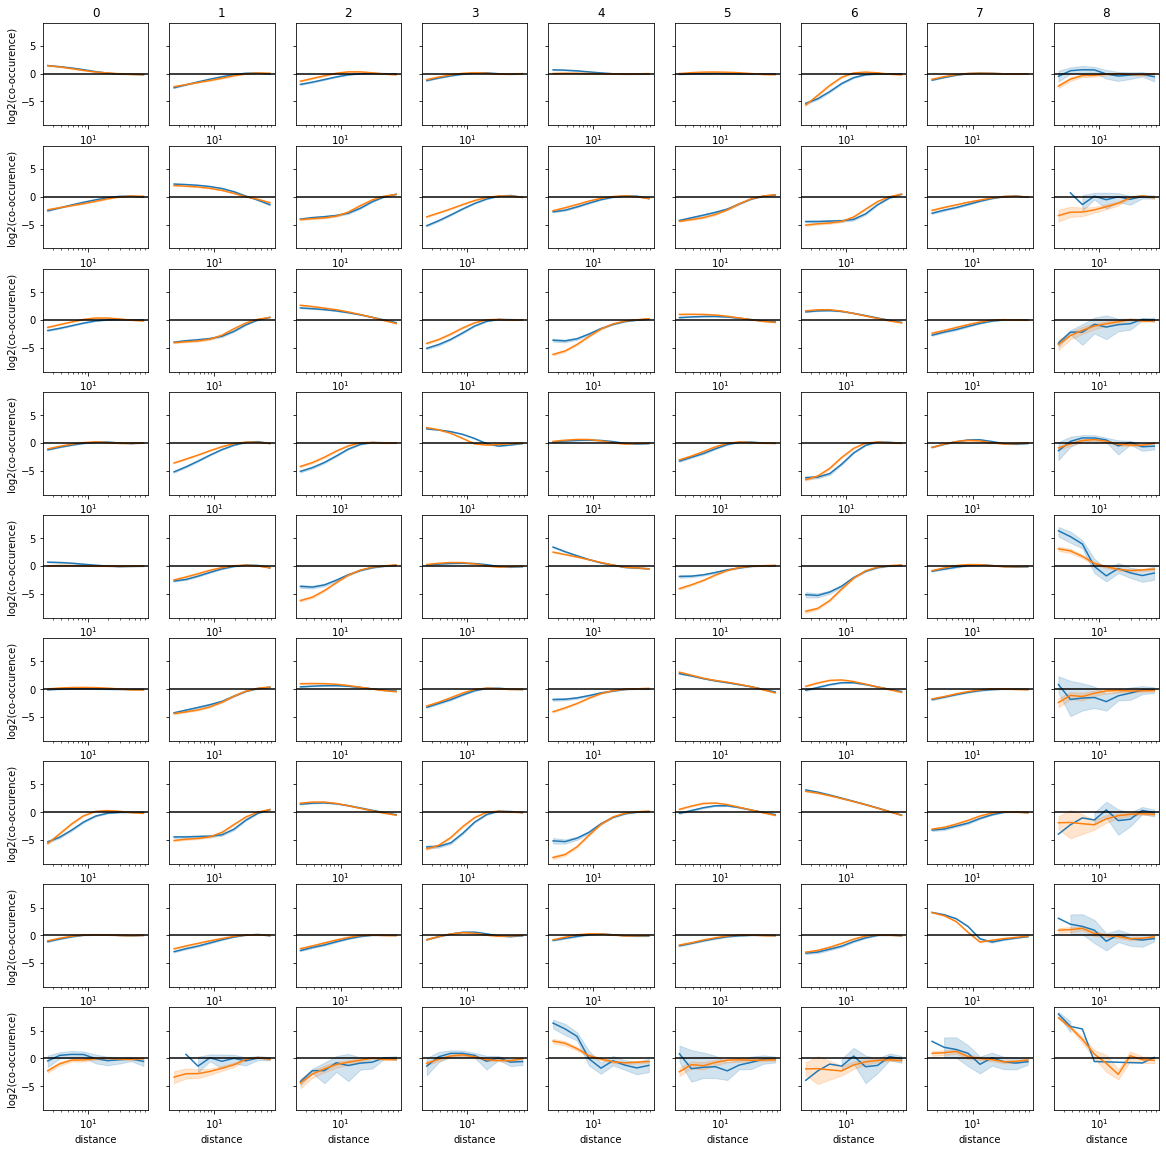

In [103]:
# for all cluster pairings
fig, axes = plot_co_occurrence_grid(adata, condition, condition_values, legend=False, ci=95, figsize=(20,20))

# OLD: distance between mean scores

In [232]:
import ot
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [194]:
distances = (adata.uns['co_occurence_params']['interval'][:-1] + adata.uns['co_occurence_params']['interval'][1:]) / 2
M = squareform(pdist(distances[:,np.newaxis]))

In [195]:
def _co_occ_scores(adata, condition, condition_value, cluster1, cluster2, log=True):
    scores = adata[adata.obs[condition] == condition_value].obsm[f'co_occurence_{cluster1}_{cluster2}']
    # filter nans from scores (cells in which either cluster1 or cluster2 does not exist)
    scores = scores[~np.isnan(scores).all(axis=1)]
    # rename columns to center of distance interval
    distances = (adata.uns['co_occurence_params']['interval'][:-1] + adata.uns['co_occurence_params']['interval'][1:]) / 2
    scores = scores.rename(columns={str(i): d for i,d in enumerate(distances)})
    # get log2 of co-occ scores
    if log:
        scores = scores.apply(np.log2)
    # return scores ready to plot
    return scores.melt(value_name='score', var_name='distance')

calculate distance between mean scores / intensity values

In [227]:
# calculate co-occurence distances
condition = 'perturbation_duration'

adata.obs[condition] = adata.obs[condition].astype('category')
condition_values = adata.obs[condition].cat.categories

co_occ_dists = np.zeros((len(condition_values), len(condition_values)))
for i, v1 in enumerate(condition_values):
    for j, v2 in enumerate(condition_values):
        dists = []
        for c1 in adata.uns['clusters']:
            for c2 in adata.uns['clusters']:
                score_v1 = _co_occ_scores(adata, condition, v1, c1, c2, log=False).groupby('distance').mean()['score']
                score_v1 = score_v1 / score_v1.sum()
                score_v2 = _co_occ_scores(adata, condition, v2, c1, c2, log=False).groupby('distance').mean()['score']
                score_v2 = score_v2 / score_v2.sum()
                dists.append(ot.emd2(score_v1, score_v2, M=M))
        co_occ_dists[i,j] = np.mean(dists)

In [230]:
def _intensity_values(adata, condition, condition_value, cluster):
    return adata[adata.obs[condition] == condition_value].layers[f'intensity_{cluster}']

# calculate intensity distances
intensity_dists = np.zeros((len(condition_values), len(condition_values)))
for i, v1 in enumerate(condition_values):
    for j, v2 in enumerate(condition_values):
        dists = []
        for c in adata.uns['clusters']:
            val1 = _intensity_values(adata, condition, v1, c).mean(axis=0)
            val2 = _intensity_values(adata, condition, v2, c).mean(axis=0)
            dists.append(np.mean(np.abs(val1 - val2)))
        intensity_dists[i,j] = np.mean(dists)

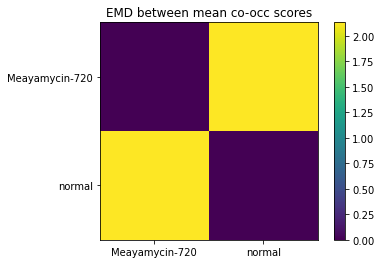

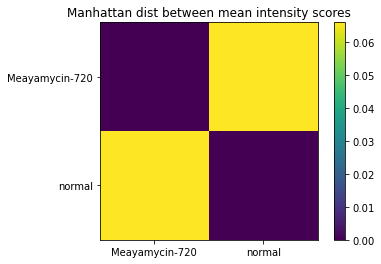

In [231]:
plt.imshow(co_occ_dists)
plt.xticks(range(len(condition_values)), labels=condition_values)
plt.yticks(range(len(condition_values)), labels=condition_values)
plt.title('EMD between mean co-occ scores')
plt.colorbar()

plt.figure()

plt.imshow(intensity_dists)
plt.xticks(range(len(condition_values)), labels=condition_values)
plt.yticks(range(len(condition_values)), labels=condition_values)
plt.title('Manhattan dist between mean intensity scores')
plt.colorbar()

## Analyse features: calculate distances between groups using different features

calculate neigbors of single-cell data with appropriate distance metrics (l1)
- plot on UMAP
- calculate distances of perturbations using neighborhood enrichment or average silhouette width


In [326]:
from scipy.spatial.distance import cityblock
def calc_co_occ_knn(adata, cluster_pairs=None, key_added='co_occurrence'):
    """
    Calculate knn graph using co_occurrence scores.

    Args:
        adata: concatenated feature adata containing co_occurrence scores in adata.obsm
        cluster_pairs: list of cluster tuples that should be used to calculate neighborhood graph. 
            If none, all available cluster pairs are used

    adds 
    - adata.obsm[key_added] containing representation used for calculating neighborhood graph
    - adata.obsp[key_added_connectivities] neighborhood graph representation
    """
    # pick cluster pairings to include in co-occ neighborhood graph
    if cluster_pairs is None:
        cluster_pairs = [(c1, c2) for c1 in adata.uns['clusters'] for c2 in adata.uns['clusters']]
    co_occ_keys = [f'co_occurence_{c1}_{c2}' for c1, c2 in cluster_pairs]

    # build combined co-occ matrix
    arr = np.concatenate([adata.obsm[k] for k in co_occ_keys], axis=1)
    # replace nans with 0
    arr[np.isnan(arr)] = 0
    adata.obsm[key_added] = arr

    # weights to use for l1 distance
    distances = (adata.uns['co_occurence_params']['interval'][:-1] + adata.uns['co_occurence_params']['interval'][1:]) / 2
    
    # calculate knn graph
    sc.pp.neighbors(adata, use_rep=key_added, n_pcs=0, metric=cityblock, metric_kwds={'w': np.tile(distances/np.mean(distances), len(cluster_pairs))}, key_added=key_added)

def calc_intensity_knn(adata, clusters=None, key_added='intensity'):
    """
    Calculate knn graph using mean cluster intensity.

    Args:
        adata: concatenated feature adata containing intensity scores in adata.obsm
        clusters: list of cluster names that should be used to calculate neighborhood graph.
            If none, all available cluster pairs are used.

    adds
    - adata.obsm[key_added] containing representation used for calculating neighborhood graph
    - adata.obsp[key_added_connectivities] neighborhood graph representation
    """
    # pick cluster pairings to include in co-occ neighborhood graph
    if clusters is None:
        clusters = adata.uns['clusters']
    intensity_keys = [f'intensity_{c}' for c in clusters]
    
    # build combined intensity matrix
    arr = np.concatenate([adata.layers[k] for k in intensity_keys], axis=1)
    # replace nans with 0
    arr[np.isnan(arr)] = 0
    adata.obsm[key_added] = arr
    
    # calculate knn graph
    sc.pp.neighbors(adata, use_rep=key_added, n_pcs=0, metric='l1', key_added=key_added)


In [319]:
exp = Experiment.from_dir('test/CondVAE_pert-CC')
# load and concat all adatas
extrs = [FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features.h5ad')) for data_dir in exp.data_params['data_dirs']]

# get combined adata
adata = ad.concat([extr.adata for extr in extrs], index_unique='-', uns_merge='same')

INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.005
INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.005
INFO:Experiment:Setting up experiment test/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in test/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.005


In [331]:
calc_co_occ_knn(adata, key_added='co_occurrence')
adata.obsm['X_co_occurrence_umap'] = sc.tl.umap(adata, neighbors_key='co_occurrence', copy=True).obsm['X_umap']

In [327]:
calc_intensity_knn(adata, key_added='intensity')
adata.obsm['X_intensity_umap'] = sc.tl.umap(adata, neighbors_key='intensity', copy=True).obsm['X_umap']

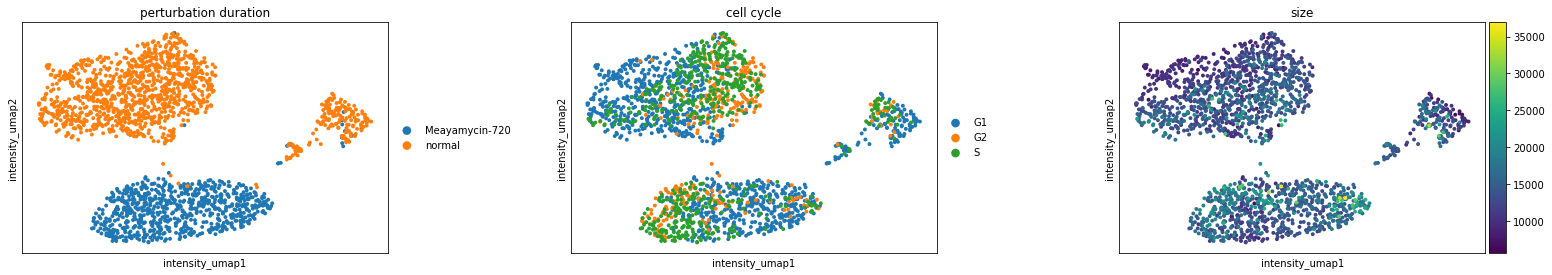

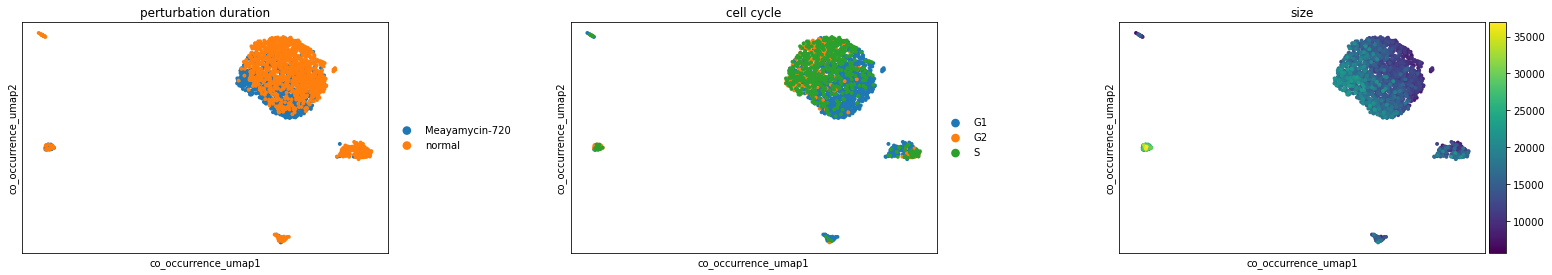

In [332]:
adata.obs['size'] = adata.obsm['size']['all']
sc.pl.scatter(adata, basis='intensity_umap', color=['perturbation_duration', 'cell_cycle', 'size'])
sc.pl.scatter(adata, basis='co_occurrence_umap', color=['perturbation_duration', 'cell_cycle', 'size'])

In [334]:
from sklearn.metrics import silhouette_score
# calculate silhouette score
key = 'co_occurrence'
distances = (adata.uns['co_occurence_params']['interval'][:-1] + adata.uns['co_occurence_params']['interval'][1:]) / 2
distances = np.tile(distances/np.mean(distances), int(adata.obsm[key].shape[1] / len(distances)))
print(silhouette_score(adata.obsm[key], labels=adata.obs['perturbation_duration'], metric=cityblock, w=distances))

print(silhouette_score(adata.obsm['intensity'], labels=adata.obs['perturbation_duration'], metric='l1'))

0.03568306511043573
0.12356551226728708


In [336]:
# calculate neighbohood enrichment
sq.gr.nhood_enrichment(adata, cluster_key='perturbation_duration', connectivity_key='co_occurrence', n_perms=300, numba_parallel=False)
print(adata.uns['perturbation_duration_nhood_enrichment'])

sq.gr.nhood_enrichment(adata, cluster_key='perturbation_duration', connectivity_key='intensity', n_perms=300, numba_parallel=False)
print(adata.uns['perturbation_duration_nhood_enrichment'])

100%|██████████| 300/300 [00:06<00:00, 44.81/s]


{'zscore': array([[ 14.81885692, -51.05524945],
       [-51.05524945,  15.81385188]]), 'count': array([[11368,  5582],
       [ 5582, 25484]], dtype=uint32)}


100%|██████████| 300/300 [00:04<00:00, 60.72/s]


{'zscore': array([[  70.50615876, -115.79497252],
       [-115.79497252,   44.36310401]]), 'count': array([[15298,   420],
       [  420, 24468]], dtype=uint32)}
